In [55]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
import random
# from sklearn import tree
from sklearn.metrics import (
    accuracy_score,f1_score,
    precision_score,recall_score, 
    confusion_matrix, ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

In [56]:
#read in all of our product data
product_data = pd.read_csv('../data/master_product_list.csv')
#make it so that the IDs match up for joins
product_data['prodSiteID'] = product_data['prodSiteID'].str.upper()

#read in all of our review data
review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')
#make it so that the IDs match up for joins
review_data['prodSiteID'] = review_data['prodSiteID'].str.upper()

#merge some key variables from the products dataframe
#into the review dataframe for supporting model building and 
#analysis
review_data = review_data.merge(
    right=pd.DataFrame(
      product_data[
        [
            'product_price','prodSiteID',
            'prod_subjectivity','total_star_rating','site'
        ]
      ]
    ),
    on='prodSiteID',
    how='left'
)

review_data.head()

C:\Users\uttar\AppData\Local\Temp\ipykernel_2356\1045152221.py:7: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  review_data = pd.read_csv('../data/all_reviews_without_unicode.csv')


,productID,prodSiteID,review_header,reviewer_name,review_content,review_star_rating,review_helpful_votes,verified_purchase,review_subjectivity,review_polarity,...,review_lang,site_x,site_outlier,site_outlier_en,global_outlier,global_outlier_en,product_price,prod_subjectivity,total_star_rating,site_y
0,1,AMAZON1,It is renewed but looked like new,Andre,"It was packaged very well, Amazon packaging, n...",5,1,True,0.588232,0.258266,...,en,Amazon,0,0,0,0,664.71,0.497845,4.2,amazon
1,1,AMAZON1,Worth it,Alice,"The phone came in perfect conditions, without ...",5,2,True,0.430909,0.447273,...,en,Amazon,0,0,0,0,664.71,0.497845,4.2,amazon
2,1,AMAZON1,Amazon Warehouse for the Win!,Mrs. K,I got a great deal on this at Amazon Warehouse...,5,2,True,0.554959,0.394215,...,en,Amazon,0,0,0,0,664.71,0.497845,4.2,amazon
3,1,AMAZON1,Awesome,David Chaves Rojas,"Got my phone, 10/10. No scratches, still have ...",5,0,True,1.000000,1.000000,...,en,Amazon,2,2,0,0,664.71,0.497845,4.2,amazon
4,1,AMAZON1,Like new iPhone 14,Rick,The iPhone 14 came with a battery that had 100...,5,0,True,0.636364,0.424242,...,en,Amazon,0,0,0,0,664.71,0.497845,4.2,amazon


In [57]:
review_data.columns

Index(['productID', 'prodSiteID', 'review_header', 'reviewer_name',
       'review_content', 'review_star_rating', 'review_helpful_votes',
       'verified_purchase', 'review_subjectivity', 'review_polarity',
       'review_length', 'url', 'review_lang', 'site_x', 'site_outlier',
       'site_outlier_en', 'global_outlier', 'global_outlier_en',
       'product_price', 'prod_subjectivity', 'total_star_rating', 'site_y'],
      dtype='object')

In [58]:
review_data['is_helpful'] = np.select(
    [
        review_data['review_helpful_votes'] > 0,
        review_data['review_helpful_votes'] == 0 | review_data['review_helpful_votes'].isna(),
    ],
    [
        1,
        0
    ]
)

In [59]:
oversampled_data = (review_data[review_data['is_helpful'] == 1]).sample(n=len(review_data[review_data['is_helpful'] == 0]), replace=True, random_state=42)
balanced_data = pd.concat([review_data[review_data['is_helpful'] == 0], oversampled_data])
review_data_new = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

review_data_new.shape

(87416, 23)

In [60]:
#this dataframe can be used for training and testing initially.
#there may still be outliers within this dataset, and as such,
#we may need to filter them down prior to training and testing
#our models.
review_data_new = pd.DataFrame(
    review_data_new[
        (review_data_new['productID'].isin([1,2,3,5,6,8,9,11,12,13,14,15])) &
        (review_data_new['review_lang']=='en')
    ]
)

In [61]:
#not sure if this is needed, but it's available to help support
# filtering data when/where needed.   
review_metrics = pd.read_csv('../data/combined_review_metrics.csv')

In [62]:
#this is a dataframe where we can capture our metrics for each
#run of each model as we seek to optimize.
#there is example code in the blocks below to help us 
#add the metrics to this frame progressively.
test_metrics = pd.DataFrame(
    {
        'Model':[],
        'Accuracy':[],
        'F1':[],
        'Precision':[],
        'Recall':[]
    }
)

In [63]:
from sklearn.preprocessing import StandardScaler

X,y = [review_data_new[
    ['review_star_rating','verified_purchase','review_subjectivity',
    'review_polarity', 'review_length','product_price', 'prod_subjectivity', 'total_star_rating']
],review_data_new['is_helpful']]

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train,X_test,y_train,y_test = train_test_split(
    X,
    y,
    test_size=0.8,
    random_state=123
)

In [64]:
random.seed(123)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
test_metrics.loc[len(test_metrics)] = {
    'Model':'K-Nearest Neighbors',
    'Accuracy':accuracy_score(y_test,y_pred),
    'F1':f1_score(y_test,y_pred),
    'Precision':precision_score(y_test,y_pred),
    'Recall':recall_score(y_test,y_pred)
}

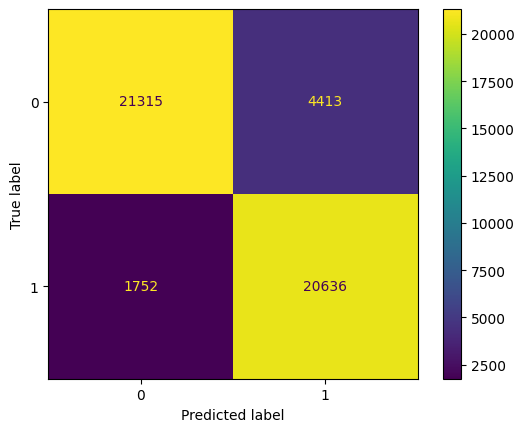

In [65]:
ConfusionMatrixDisplay(confusion_matrix(y_test,y_pred)).plot()

In [66]:
display(test_metrics)

,Model,Accuracy,F1,Precision,Recall
0,K-Nearest Neighbors,0.871872,0.870038,0.823825,0.921744
